In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.optim as opt

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

import torchtext
from torchtext.data.utils import get_tokenizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
import spacy
from collections import Counter

bptt = 40

freq_list = Counter()
word_to_id_dict = {}
id_to_word_dict = {}

word_to_id_dict["<pad>"] = 0
id_to_word_dict[0] = "<pad>"

next_id = 1
train = []

# Tokenize sentence
def generate_dataset(filename, word_to_id_dict, id_to_word_dict, next_id):
  result = []
  lang_model = spacy.load('en', disable=['tagger', 'parser', 'ner'])
  was = set()
  with open(filename, 'r') as file:
    for i, sentence in enumerate(file):
      sentence = sentence.lower().rstrip('\n')
      sentence = [tok.text for tok in lang_model.tokenizer(sentence) if not tok.text.isspace()]
      lemmzed = " ".join(sorted([wordnet_lemmatizer.lemmatize(x) for x in sentence]))
      if lemmzed in was:
          continue
      was.add(lemmzed)
      sentence = ["<sos>"] + sentence
      if len(sentence) > bptt or len(sentence) < 7:
        continue
      sentence += ['<pad>'] * max(0, bptt - len(sentence))
      
      for word in sentence:
        if not word in word_to_id_dict:
          word_to_id_dict[word] = next_id
          id_to_word_dict[next_id] = word
          next_id += 1
      
      sentence = [word_to_id_dict[word] for word in sentence]
      freq_list.update(sentence)
      
      sentence_segments = [np.array(sentence[i:i + bptt]) for i in range(len(sentence) - bptt + 1)]

      result.append(sentence_segments)
  return result, next_id

train, next_id = generate_dataset(path_to_data + 'train.txt', word_to_id_dict, id_to_word_dict, next_id)
validate, next_id = generate_dataset(path_to_data + 'valid.txt', word_to_id_dict, id_to_word_dict, next_id)
test, next_id = generate_dataset(path_to_data + 'test.txt', word_to_id_dict, id_to_word_dict, next_id)

In [0]:
train = np.array(list(map(np.array, train)))
np.random.shuffle(train)
test = np.array(sum(test, []))[:100]
validate = np.array(sum(validate, []))[:100]

In [7]:
dim = 50

word_to_glove = {}
with open("/content/drive/My Drive/Colab Notebooks/glove.6B.50d.txt", 'r') as glove:
  for line in glove:
    tokens = line.rstrip().split()
    word = tokens[0]
    if word not in word_to_glove and word in word_to_id_dict:
      emb = torch.from_numpy(np.array([list(map(float, tokens[1:]))])).float()
      word_to_glove[word] = emb

emb_tensor = torch.tensor([]).float()
for i, word in id_to_word_dict.items():
  if word in word_to_glove:
    emb = word_to_glove[word]
  else:
    emb = torch.from_numpy(np.random.uniform(-1., 1., size=dim).reshape(1, -1)).float()
  emb_tensor = torch.cat((emb_tensor, emb))

print(emb_tensor)

tensor([[ 0.5401, -0.9919,  0.0966,  ..., -0.2318,  0.6757, -0.7559],
        [-0.4823,  0.6175,  0.9280,  ..., -0.3485, -0.0172,  0.4641],
        [ 0.4532,  0.0598, -0.1058,  ...,  0.5324, -0.2510,  0.6255],
        ...,
        [ 1.2031, -0.4003,  0.0740,  ...,  1.3262, -0.3325,  0.8198],
        [-0.4364,  0.6623,  0.9707,  ...,  0.0869,  0.9431,  0.8322],
        [ 0.7192, -0.9104,  0.9343,  ..., -0.1853,  0.3997,  0.3091]])


In [8]:
len(train)

47167

In [9]:
print(emb_tensor.shape)
len(word_to_id_dict)

torch.Size([30234, 50])


30234

In [0]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.2, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [0]:
class TransformetGenerator(nn.Module):
  def __init__(self, emb_size, src_dict_len, tgt_dict_len, max_len, embs=None):
    super(TransformetGenerator, self).__init__()
    self.src_emb = nn.Embedding(src_dict_len, emb_size)
    if embs is not None:
      self.src_emb.from_pretrained(embs, freeze=False)
    #self.tgt_emb = nn.Embedding(tgt_dict_len, emb_size)

    self.d_model = emb_size
    self.pos_enc = PositionalEncoding(emb_size, max_len=max_len)
    self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(emb_size, 10, dropout=0.1), 6)
    self.linear = nn.Linear(emb_size, tgt_dict_len)
    self.softmax = nn.Softmax(dim=2)
    self.src_mask = None

    """
    initrange = 0.1
    self.src_emb.weight.data.uniform_(-initrange, initrange)
    #self.tgt_emb.weight.data.uniform_(-initrange, initrange)
    self.linear.bias.data.zero_()
    self.linear.weight.data.uniform_(-initrange, initrange)"""

  def forward(self, src, tgt):
    # src & tgt dimensions (batch_size, words)

    src_padding_mask = (src == 0).to(src.device)
    #tgt_padding_mask = (tgt == 0).to(src.device)
    memory_mask = src_padding_mask.clone().to(src.device)

    #tgt_mask = (torch.triu(torch.ones(tgt.shape[1], tgt.shape[1])) == 1).float()
    #tgt_mask = tgt_mask.masked_fill(tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0)).transpose(0, 1).to(src.device)
    
    if self.src_mask is None or self.src_mask.shape[0] != src.shape[1]:
      src_mask = (torch.triu(torch.ones(src.shape[1], src.shape[1])) == 1).float()
      self.src_mask = src_mask.masked_fill(src_mask == 0, float('-inf')).masked_fill(src_mask == 1, float(0.0)).transpose(0, 1).to(src.device)
    
    src = src.transpose(1, 0)
    #tgt = tgt.transpose(1, 0)
    # src & tgt dimensions (words, batch_size)
    src = self.src_emb(src)
    #tgt = self.tgt_emb(tgt)
    # src & tgt dimensions (words, batch_size, embs)
    src = self.pos_enc(src * math.sqrt(self.d_model))
    #tgt = self.pos_enc(src * math.sqrt(self.d_model))
    output = self.transformer(src, #tgt,
                              mask=self.src_mask,
    #                          tgt_mask=tgt_mask,
    #                          memory_key_padding_mask=memory_mask,
                              src_key_padding_mask=src_padding_mask,
    #                          tgt_key_padding_mask=tgt_padding_mask
                              )
    #output shape: (words, batch_size, emb)
    output = output.transpose(1, 0)
    # output shape: (batch_size, words, emb)
    # embeddings to probabilities:
    output = self.linear(output)
    output = self.softmax(output)
    return output
    

In [0]:
def learn(device, model, loss_function, epoches, batch_size, optimizer):
    train_losses = []
    validate_losses = []
    iters_per_epoch = len(train)

    v = torch.from_numpy(validate).to(device)
    t = torch.from_numpy(test).to(device)
    

    for epoch in range(epoches):
        np.random.shuffle(train)
        optimizer.zero_grad()
        # np.random.shuffle(train)
        cnt = 0
        while True:
            batch = np.array([])
            while batch.shape[0] < batch_size:
              if cnt >= len(train):
                break
              if batch.shape[0]:
                batch = np.concatenate((batch, train[cnt]))
              else:
                batch = train[cnt]
              cnt += 1
            if batch.shape[0] < batch_size:
              break

            batch = torch.from_numpy(batch).to(device)

            train_error    = loss_function(model.forward(batch, batch), batch)
            validate_error = loss_function(model.forward(v, v), v)

            train_losses.append(float(train_error))
            validate_losses.append(float(validate_error))

            print("Epoch {}/{}. Iteration {}/{} Losses: train: {}, validate: {}"
              .format(epoch, epoches, cnt, iters_per_epoch, train_losses[-1], validate_losses[-1]))

            train_error.backward()   
            optimizer.step()
            optimizer.zero_grad()
    test_loss = float(loss_function(model.forward(t, t), t))
    return train_losses, validate_losses, test_loss

In [131]:
device = torch.device('cuda')
torch.cuda.empty_cache()
model = TransformetGenerator(dim, len(word_to_id_dict), len(word_to_id_dict), bptt, embs=emb_tensor).to(device)
optimizer = opt.Adam(model.parameters())
def loss(res, b):
  x = b[:, 1:].view(b.shape[0], b.shape[1] - 1, -1).to(device)
  from_ones = torch.gather(res[:, :-1, :], 2, x)
  los = (- torch.sum((1 - from_ones).log()) + torch.sum((1 - res[:, :-1, :]).log()))
  err = - los / (torch.tensor(b.shape[0] * (b.shape[1] - 1) * res.shape[2]).to(device)) - torch.sum(from_ones.log()) / b.shape[0] / (b.shape[1] - 1)
  return err

train_losses, validate_losses, test_loss = learn(device, model, loss, 10, 100, optimizer)

Epoch 0/10. Iteration 100/47167 Losses: train: 10.16590404510498, validate: 10.13668441772461
Epoch 0/10. Iteration 200/47167 Losses: train: 8.677658081054688, validate: 8.64410400390625
Epoch 0/10. Iteration 300/47167 Losses: train: 8.289255142211914, validate: 8.380843162536621
Epoch 0/10. Iteration 400/47167 Losses: train: 8.11864948272705, validate: 8.28111457824707
Epoch 0/10. Iteration 500/47167 Losses: train: 8.062396049499512, validate: 8.218608856201172
Epoch 0/10. Iteration 600/47167 Losses: train: 8.1345853805542, validate: 8.15282154083252
Epoch 0/10. Iteration 700/47167 Losses: train: 8.057779312133789, validate: 8.087459564208984
Epoch 0/10. Iteration 800/47167 Losses: train: 8.002664566040039, validate: 8.012243270874023
Epoch 0/10. Iteration 900/47167 Losses: train: 7.971149444580078, validate: 7.936307430267334
Epoch 0/10. Iteration 1000/47167 Losses: train: 7.8749189376831055, validate: 7.860538005828857
Epoch 0/10. Iteration 1100/47167 Losses: train: 7.75209093093872

Likelihood by iteration.


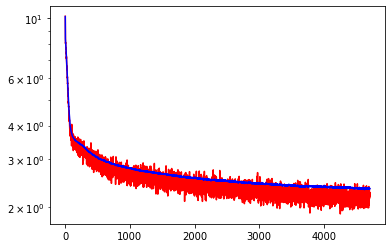

In [132]:
print("Likelihood by iteration.")
plt.yscale('log')
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(validate_losses)), validate_losses, 'b')

In [ ]:
model.eval()

words = 40
ph = ""
tr = 64
print(ph, end=' ')
sent = [word_to_id_dict[x] for x in "<sos> {}".format(ph).split()]
for _ in range(words):
  x = np.array(sent[-bptt + 1::] + [0]).reshape(1, min(len(sent) + 1, bptt))
  x = torch.from_numpy(x).to(device)
  probs = sorted(list(enumerate(model.forward(x, x)[0][-2].cpu().detach().numpy().tolist())), key=lambda x: x[1], reverse=True)[:tr]
  ids = [x[0] for x in probs]
  ps = [x[1] for x in probs]
  tr = max(2, tr // 2)

  word_id = random.choices(ids, ps)[0]

  word = id_to_word_dict[word_id]
  #if word_id != 0:
  print(word, end=' ')
  sent.append(word_id)